In [82]:
# Imports
from compressors import lz77, huffman, wlz77, huffword
import os, re
from wordcloud import WordCloud, STOPWORDS
# Python numbers and plots
import pandas as p
import numpy as np
import matplotlib.pyplot as plt

#Sklearn import
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA


In [83]:
def load_dataset(datset_name):
    f_path = 'dataset/stack-exchange-tags/{dataset}.csv'.format(dataset = datset_name)
    fullf_path = os.path.join(os.getcwd(), f_path)
    return p.read_csv(fullf_path, index_col=0, nrows=1500)

ds_names = ['biology', 'cooking', 'crypto', 'diy', 'robotics', 'travel']
frames = [load_dataset(name) for name in ds_names]
df = p.concat(frames)

#parameters
n_clusters = 3
n_partitions = 3

In [84]:
stop_words = set(STOPWORDS)

# # Sanitizing columns
def sanitize_column(data):
    '''
        Function to cleaning text for a better analysis
    '''

    # convert to lower
    data = data.lower()
    
    # strip html
    data = re.sub(r'\<[^<>]*\>','',data.lower())

    #removing pontuation
    data = re.sub(r'[^a-zA-Z0-9]',' ',data)

    # Remove new lines and tabs
    data = re.sub(r'\s',' ',data)

    #strip data
    data = data.strip()

    #Spling words
    data = data.split()
    
    #Remove extra blank space
    data = list(filter(lambda s: s != ' ', data))

    # Remove stop words
    data =  list(filter(lambda s: s not in stop_words,data))

    #remove single chars words
    data = list(filter(lambda s: len(s) > 1, data))

    return data

def array_column_to_text(column):
    text = ''
    for w in column:
        for s in w:
            text += ' ' + s 
    return text

        
df['sanitezed_content'] = df['content'].apply(sanitize_column)
df['sanitezed_title'] = df['title'].apply(sanitize_column)

df.head(10)



,title,content,tags,sanitezed_content,sanitezed_title
id,,,,,
1,What is the criticality of the ribosome bindin...,"<p>In prokaryotic translation, how critical fo...",ribosome binding-sites translation synthetic-b...,"[prokaryotic, translation, critical, efficient...","[criticality, ribosome, binding, site, relativ..."
2,How is RNAse contamination in RNA based experi...,<p>Does anyone have any suggestions to prevent...,rna biochemistry,"[anyone, suggestions, prevent, rnase, contamin...","[rnase, contamination, rna, based, experiments..."
3,Are lymphocyte sizes clustered in two groups?,<p>Tortora writes in <em>Principles of Anatomy...,immunology cell-biology hematology,"[tortora, writes, principles, anatomy, physiol...","[lymphocyte, sizes, clustered, two, groups]"
4,How long does antibiotic-dosed LB maintain goo...,<p>Various people in our lab will prepare a li...,cell-culture,"[various, people, lab, will, prepare, liter, l...","[long, antibiotic, dosed, lb, maintain, good, ..."
5,Is exon order always preserved in splicing?,<p>Are there any cases in which the splicing m...,splicing mrna spliceosome introns exons,"[cases, splicing, machinery, constructs, mrna,...","[exon, order, always, preserved, splicing]"
6,How can I avoid digesting protein-bound DNA?,<p>I'm interested in sequencing and analyzing ...,dna biochemistry molecular-biology,"[interested, sequencing, analyzing, bound, dna...","[avoid, digesting, protein, bound, dna]"
8,Under what conditions do dendritic spines form?,<p>I'm looking for resources or any informatio...,neuroscience synapses,"[looking, resources, information, formation, d...","[conditions, dendritic, spines, form]"
9,How should I ship plasmids?,<p>I shipped 10 µL of my vector miniprep to a ...,plasmids,"[shipped, 10, vector, miniprep, collaborator, ...","[ship, plasmids]"
10,What is the reason behind choosing the reporte...,<p>I noticed within example experiments in cla...,molecular-genetics gene-expression experimenta...,"[noticed, within, example, experiments, class,...","[reason, behind, choosing, reporter, gene, exp..."


**Show clusters for subject and body**

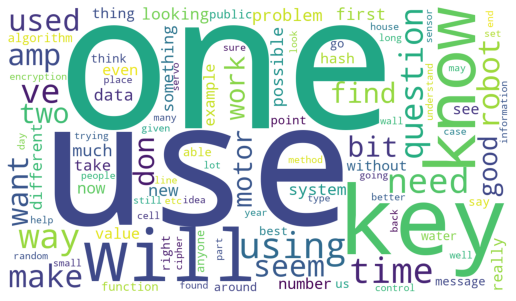

In [85]:
w_cloud = WordCloud(
    collocations=False,
    width=1400, height=800,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    random_state=42).generate(array_column_to_text(df['sanitezed_content']))

plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(w_cloud)
plt.axis('off')
plt.show()


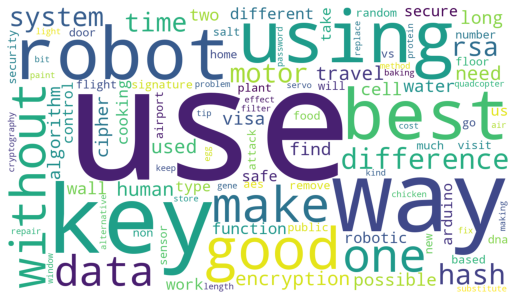

In [86]:
w_cloud = WordCloud(
    collocations=False,
    width=1400, height=800,
    background_color='white',
    stopwords=stop_words,
    max_words=100,
    random_state=42).generate(array_column_to_text(df['sanitezed_title']))

plt.figure(figsize=(9,8))
fig = plt.figure(1)
plt.imshow(w_cloud)
plt.axis('off')
plt.show()

## 2. Compressing data without clusterization partition

In [87]:
# Data to compress: Compress the original data raw
raw_text = df['content']

#Shuffle raw text
shuffle = raw_text.sample(frac=1)
partitions = np.array_split(shuffle, n_partitions)

In [88]:
#Initializing encoders
huffman_encoder = huffman.HuffmanCompressor()
lz77_encoder = lz77.Lz77Compressor()
huff8_encoder = huffword.HuffwordCompressor()
wlz77_encoder = wlz77.WLz77Compressor()


In [89]:
#Encode by Huffman
def run_on_partitions(n_paritions, encoder, paritions):
    sum_rate = 0
    for n in range(n_paritions):
        encoder.encode(paritions[n].sum())
        sum_rate += encoder.stats._compression_rate()
    
    return sum_rate / n_paritions

In [90]:
%%time
huff_rate = run_on_partitions(n_partitions, huffman_encoder, partitions)
display(huff_rate)

#Asserting that the text is being corrected decoded
# assert huffman_encoder.originaltext == huffman_encoder.decode()

39.44535879125955

CPU times: user 806 ms, sys: 22 ms, total: 828 ms
Wall time: 702 ms


In [91]:
%%time
lz77_rate = run_on_partitions(n_partitions, lz77_encoder, partitions)
display(lz77_rate)


#Asserting that the text is being corrected decoded
# assert lz77_encoder.originaltext == lz77_encoder.decode()

39.20131916115273

CPU times: user 1min 42s, sys: 13.7 s, total: 1min 55s
Wall time: 1min 55s


In [92]:
%%time
huff8_rate = run_on_partitions(n_partitions, huff8_encoder, partitions)
display(huff8_rate)

#Asserting that the text is being corrected decoded
# assert huff8_rate.originaltext == huff8_rate.decode()

44.531812589223115

CPU times: user 1.09 s, sys: 28.6 ms, total: 1.12 s
Wall time: 1.12 s


In [93]:
%%time
wlz77_rate = run_on_partitions(n_partitions, wlz77_encoder, partitions)
display(wlz77_rate)

#Asserting that the text is being corrected decoded
# assert wlz77_rate.originaltext == wlz77_rate.decode()

28.060714058062278

CPU times: user 20min 19s, sys: 1min 18s, total: 21min 38s
Wall time: 21min 40s


#### Plot results from non cluster data

***Comparing compression rates***

/var/folders/b2/3n2dwwc92tl814w2xmqy38g40000gp/T/ipykernel_21905/3896455028.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color = 'gray', linestyle = '-.', linewidth = 0.5, alpha = 0.2)


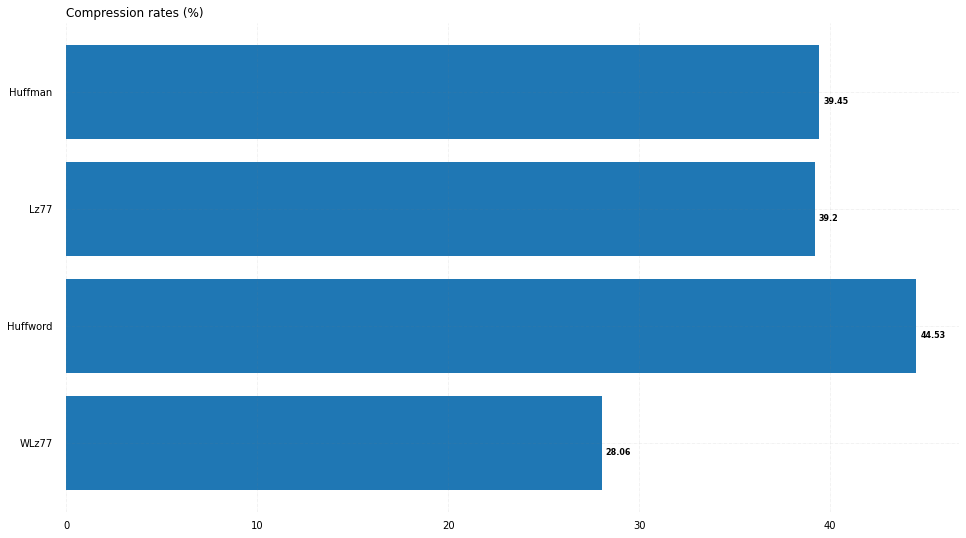

In [94]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
algs = ["Huffman", "Lz77", "Huffword", "WLz77"]
percents = [huff_rate, lz77_rate, huff8_rate, wlz77_rate]

# Bar plot for horizontal plot
ax.barh(algs, percents)

# Remove vertical bar settings
for dir in ['top', 'bottom', 'left', 'right']:
    ax.spines[dir].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Draw settings for horizontal bars settings
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color = 'gray', linestyle = '-.', linewidth = 0.5, alpha = 0.2)

# Top Values
ax.invert_yaxis()

# Add annotation
for index in ax.patches:
    plt.text(index.get_width()+0.2, index.get_y()+0.5, str(round((index.get_width()), 2)),
             fontsize = 8, fontweight ='bold', color ='black')

# Title
ax.set_title('Compression rates (%)', loc='left')

plt.show()
 

## 3. Compressing data with k-means clusterization

**TF/IDF Vectorization** : Relevant words score

In [95]:
def identity_tokenizer(text):
  return text

vect = TfidfVectorizer(tokenizer=identity_tokenizer,lowercase=False)
tf_idf = vect.fit_transform(df['sanitezed_content'].values)
tf_idf_norm = normalize(tf_idf) # To PCA running
tf_idf_arr = tf_idf_norm.toarray()
p.DataFrame(tf_idf_arr, columns=vect.get_feature_names()).head(10)

/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,00,000,0000,000000,000000000,0000000000000,00000000000000000000000000000000,0001,000102030405060708090a0b0c0d0e0f101112131415161718191a1b1,0002,...,zucchinis,zurich,zuuzfukuxzkeksfu,zx,zxing,zy,zygote,zymolyase,zymoprep,zz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**PCA components** : Transform dimensions to keep only meaningfull data

In [96]:
pca = PCA(n_components=2)
Y = pca.fit_transform(tf_idf_arr)

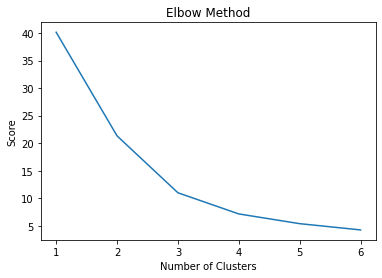

In [97]:
clusters = range(1, 7) # Range randomly defined just to analyse
n_kmeans = [KMeans(n_clusters=n) for n in clusters] # Create objects

score = [n_kmeans[n].fit(Y).score(Y) for n in range(len(n_kmeans))] # models training
score = [-i for i in score] # Normalize scores to plot

plt.plot(clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Method')
plt.show()

In [98]:
# Silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=50)
    kmeans.fit(Y)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(Y, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.6903363909911645
For n_clusters=3, the silhouette score is 0.6690789067894048
For n_clusters=4, the silhouette score is 0.6637338063299842
For n_clusters=5, the silhouette score is 0.5911106440394578
For n_clusters=6, the silhouette score is 0.6095372058040204
For n_clusters=7, the silhouette score is 0.4244048922716165
For n_clusters=8, the silhouette score is 0.4238918892983719
For n_clusters=9, the silhouette score is 0.4169223601557487
For n_clusters=10, the silhouette score is 0.38419471880545536
For n_clusters=11, the silhouette score is 0.37089470054659346
For n_clusters=12, the silhouette score is 0.3703398373344982


***Clusters visual analysis***

**Create 3 clusters to data** : Divide data into 3 clusters in order to rum the compression algorithms

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

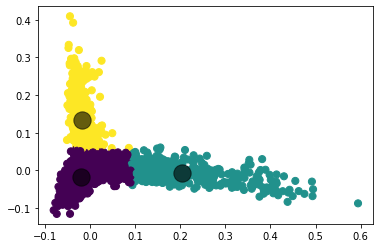

In [99]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', max_iter=50)
fit_data = kmeans.fit(Y)
pred_class = kmeans.predict(Y)

display(fit_data.labels_)
df['Cluster'] = fit_data.labels_

# Ploting clusterization with bubble format
plt.scatter(Y[:, 0], Y[:, 1], c=pred_class, s=50, cmap='viridis')

centers = fit_data.cluster_centers_
plt.scatter(centers[:, 0], centers[:,1], c='black', s=300, alpha=0.6)


/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/opt/homebrew/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/var/folders/b2/3n2dwwc92tl814w2xmqy38g40000gp/T/ipykernel_21905/1990630584.py:28: UserWarning: FixedFormatter should only be used together wi

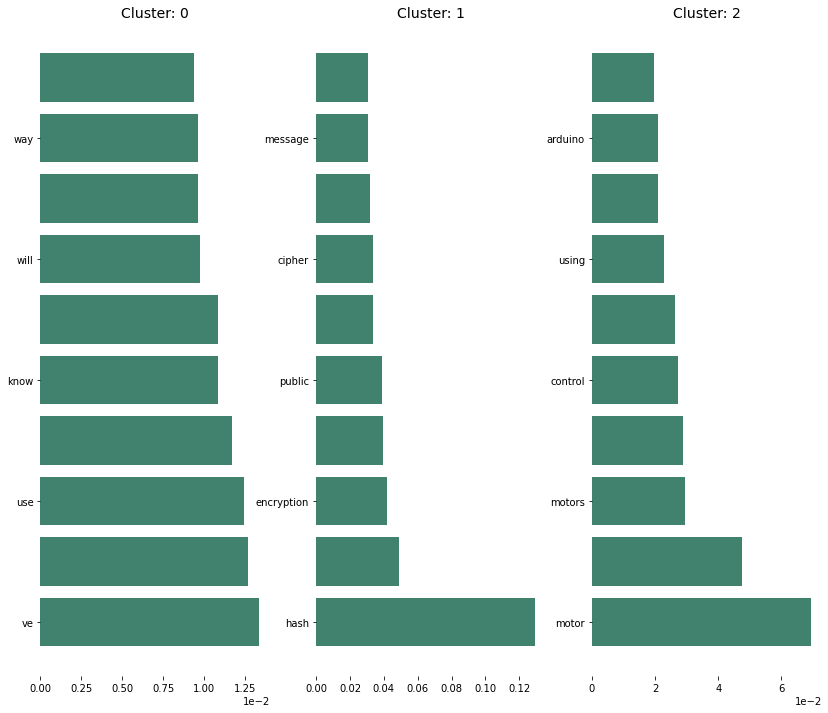

In [100]:
# Feacture extraction functions: The most used words in each cluster
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vect.get_feature_names()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = p.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plot_features(df_s):
    fig = plt.figure(figsize=(14,12))
    x = np.arange(len(df_s[0]))
    for i, df in enumerate(df_s):
        ax = fig.add_subplot(1, len(df_s), i+1)
        ax.set_title("Cluster: "+ str(i), fontsize = 14)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#40826d')
        ax.set_yticklabels(df.features)
    plt.show()

df_cluster = get_top_features_cluster(tf_idf_arr, pred_class, 10)
plot_features(df_cluster)

#### Encoding again, with clusterization

In [101]:
# weighted avg
def clusters_wmean_compression_rate(n_clusters, encoder):
    comp_rate_sum = 0
    query  = "Cluster == {n_clusters}"

    for n in range(n_clusters):
        cluster_n = df.query(query.format(n_clusters = n))
        encoder.encode(cluster_n['content'].sum(), print_stats=False)
        comp_rate_sum += encoder.stats._compression_rate() * (len(cluster_n) / len(df))

    return comp_rate_sum


In [102]:
%%time
huffman_encoder2 = huffman.HuffmanCompressor()
huff_rate2 = clusters_wmean_compression_rate(n_clusters, huffman_encoder2)

display(huff_rate2)

39.623838599732515

CPU times: user 989 ms, sys: 196 ms, total: 1.18 s
Wall time: 955 ms


In [103]:
%%time
lz77_encoder2 = lz77.Lz77Compressor()
lz77_rate2 = clusters_wmean_compression_rate(n_clusters, lz77_encoder2)

display(lz77_rate2)

40.574918303070376

CPU times: user 2min 5s, sys: 1min 5s, total: 3min 11s
Wall time: 3min 11s


In [104]:
%%time
huff8_encoder2 = huffword.HuffwordCompressor()
huff8_rate2 = clusters_wmean_compression_rate(n_clusters, huff8_encoder)

display(huff8_rate2)

49.26293270595325

CPU times: user 1.21 s, sys: 186 ms, total: 1.39 s
Wall time: 1.43 s


In [105]:
%%time
wlz77_encoder2 = wlz77.WLz77Compressor()
wlz77_rate2 = clusters_wmean_compression_rate(n_clusters, wlz77_encoder2)

display(wlz77_rate2)

30.958365812098158

CPU times: user 36min 32s, sys: 2min 39s, total: 39min 11s
Wall time: 39min 13s


***Compression rate with clustering***

/var/folders/b2/3n2dwwc92tl814w2xmqy38g40000gp/T/ipykernel_21905/1069488363.py:20: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b = True, color = 'gray', linestyle = '-.', linewidth = 0.5, alpha = 0.2)


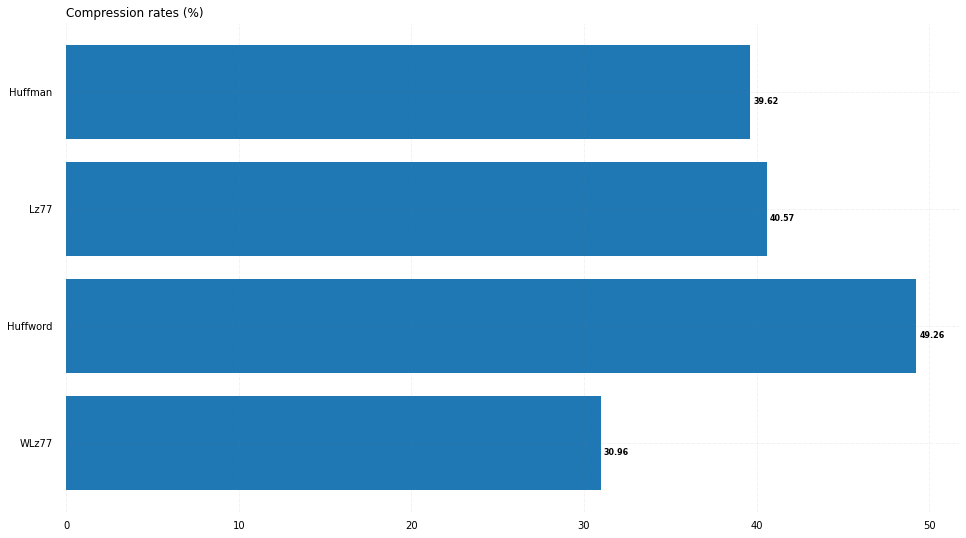

In [106]:
# Figure Size
fig, ax = plt.subplots(figsize =(16, 9))
algs = ["Huffman", "Lz77", "Huffword", "WLz77"]
percents = [huff_rate2, lz77_rate2, huff8_rate2, wlz77_rate2] 

# Bar plot for horizontal plot
ax.barh(algs, percents)

# Remove vertical bar settings
for dir in ['top', 'bottom', 'left', 'right']:
    ax.spines[dir].set_visible(False)

ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

# Draw settings for horizontal bars settings
ax.xaxis.set_tick_params(pad = 5)
ax.yaxis.set_tick_params(pad = 10)

ax.grid(b = True, color = 'gray', linestyle = '-.', linewidth = 0.5, alpha = 0.2)

# Top Values
ax.invert_yaxis()

# Add annotation
for index in ax.patches:
    plt.text(index.get_width()+0.2, index.get_y()+0.5, str(round((index.get_width()), 2)),
             fontsize = 8, fontweight ='bold', color ='black')

# Title
ax.set_title('Compression rates (%)', loc='left')

plt.show()

***Clustering vs without clusters***

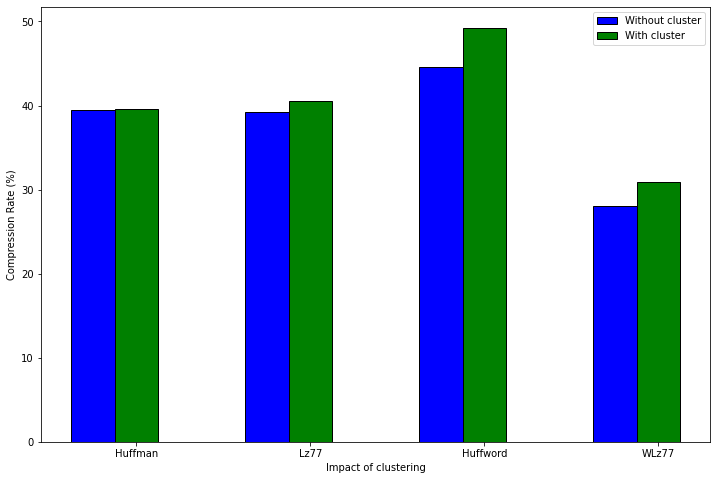

In [107]:
# Set the bar
bar_w = 0.25
fig, ax= plt.subplots(figsize = (12, 8))

# Data initialization
inputs = [huff_rate, lz77_rate, huff8_rate, wlz77_rate]
results = [huff_rate2, lz77_rate2, huff8_rate2, wlz77_rate2]

# X axis position
normal_bar = np.arange(len(inputs))
clustering_bar = [x + bar_w for x in normal_bar]

# The Plot
plt.bar(normal_bar, inputs, color='b', width=bar_w, edgecolor='black', label='Without cluster')
plt.bar(clustering_bar, results, color='g', width=bar_w, edgecolor='black', label='With cluster')

# Lables
plt.xlabel('Impact of clustering', fontsize = 10)
plt.ylabel('Compression Rate (%)', fontsize = 10)
algs = ["Huffman", "Lz77", "Huffword", "WLz77"]
plt.xticks([r + bar_w for r in range(len(inputs))], algs)

plt.legend()
plt.show()

***Clustering impact delta visualisation***

In [113]:
results = [[huff_rate, huff_rate2, huff_rate2 - huff_rate], [lz77_rate, lz77_rate2, lz77_rate2 - lz77_rate], [huff8_rate, huff8_rate2, huff8_rate2 - huff8_rate], [wlz77_rate, wlz77_rate2, wlz77_rate2 - wlz77_rate]]
df_res = p.DataFrame(results,
                     index=p.Index(['Huffman', 'Lz77', 'Huffword',  'WLz77'], name='Compressor'),
                     columns=['Parition data (%)', 'Clusterized Data (%)', 'Delta'])
df_res.style

,Parition data (%),Clusterized Data (%),Delta
Compressor,,,
Huffman,39.445359,39.623839,0.178480
Lz77,39.201319,40.574918,1.373599
Huffword,44.531813,49.262933,4.731120
WLz77,28.060714,30.958366,2.897652
